<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Обработка-текста" data-toc-modified-id="Обработка-текста-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Обработка текста</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Лемматизация</a></span></li></ul></li><li><span><a href="#Дисбаланс---downsampling" data-toc-modified-id="Дисбаланс---downsampling-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Дисбаланс - downsampling</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#baseline" data-toc-modified-id="baseline-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>baseline</a></span></li><li><span><a href="#catboost-TF-IDF" data-toc-modified-id="catboost-TF-IDF-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>catboost TF-IDF</a></span><ul class="toc-item"><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>TF-IDF</a></span></li></ul></li><li><span><a href="#BERT---модель-взята-с-HuggingFace" data-toc-modified-id="BERT---модель-взята-с-HuggingFace-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>BERT - модель взята с HuggingFace</a></span></li><li><span><a href="#Итоговое-тестирование-модели" data-toc-modified-id="Итоговое-тестирование-модели-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Итоговое тестирование модели</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» TDF-IDF and BERT from HuggingFace

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import transformers
from transformers import BertTokenizer, BertConfig
import re
import torch
import spacy
from pymystem3 import Mystem
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from catboost import CatBoostClassifier

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/artemmm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/artemmm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/artemmm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/artemmm/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /Users/artemmm/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
import os
pth1 = '/Users/artemmm/Downloads/toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, usecols=[1, 2])
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, usecols=[1, 2])
else:
    print('Something is wrong')

RANDOMSTATE = 42
#data = data.sample(8000, random_state = RANDOMSTATE)
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
data.isna().sum().sum()

0

In [4]:
data.duplicated().sum()

0

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


#### Обработка текста

In [6]:
data['text'] = data['text'].str.replace('\n', ' ')

#### Лемматизация

In [7]:
#lemmatizer = WordNetLemmatizer()
#def lemmatize_text(text):
#    text = text.lower()
#    text = re.sub(r"[^a-zA-Z]", " ", text)
#    tokens = word_tokenize(text)
#    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
#    
#    lemmatized_text = ' '.join(lemmatized_tokens)
#    return lemmatized_text
#data['lemmatized_text'] = data['text'].apply(lemmatize_text)
import spacy
nlp = spacy.load("en_core_web_sm")
def lemmatize_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z]", " ", text)
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

from tqdm.notebook import tqdm
tqdm.pandas()

data['lemmatized_text'] = data['text'].progress_apply(lemmatize_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [8]:
data = data.drop_duplicates()
data.head()

,text,toxic,lemmatized_text
0,Explanation Why the edits made under my userna...,0,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour I m se...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I m really not try to edit war it ...
3,""" More I can't make any real suggestions on im...",0,more I can t make any real suggestion on im...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you rememb...


*Сравнив два лемматайзера - WordNetLemmaizer и Spacy, могу сказать, что качество модели после обработки Spacy немного лучше, чем WordNet, но второй, в свою очередь, имеет преимущество по скорости обработки*

### Дисбаланс - downsampling
Перед началом деления на выборки необходима борьба с дисбалансом.

In [9]:
data['toxic'].sample(1000).value_counts()

toxic
0    893
1    107
Name: count, dtype: int64

In [10]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

## Обучение

### baseline

Обучаемую модель нужно с чем-либо сравнивать. В нашем случае виднеется дисбаланс классов, примерно 90% записей имеют 0 в столбце 'toxic'. Поэтому за бейзлайн возьмем моду данного признака, и все ответы на модели будут 0.

In [11]:
baseline = pd.DataFrame()
y_baseline = data['toxic'].sample(1000, random_state = RANDOMSTATE)
baseline = np.random.choice([0, 1], size=len(y_baseline), p=[0.9, 0.1])
print('f1 на baseline модели:',f1_score(y_baseline, baseline))

f1 на baseline модели: 0.045454545454545456


### catboost TF-IDF

#### TF-IDF

In [12]:
nltk.download('stopwords')
stopwords = list(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/artemmm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
features = data['lemmatized_text']
target = data['toxic']
x_train, x_test, y_train, y_test  = train_test_split(features, target,
                                                     test_size = 0.3, random_state = RANDOMSTATE)
x_test,x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5, random_state = RANDOMSTATE)
x_train, y_train = downsample(features, target, 0.1)
c_train = x_train.values
c_valid = x_valid.values
c_test_cb = x_test.values
y_test_cb = y_test
print(x_train.shape,x_test.shape, x_valid.shape)

(30495,) (23893,) (23893,)


In [14]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
c_train = count_tf_idf.fit_transform(c_train)
c_test_cb = count_tf_idf.transform(c_test_cb)
c_valid = count_tf_idf.transform(c_valid)

In [15]:
c_train.shape, c_test_cb.shape, c_valid.shape #такая матрица получилась

((30495, 50411), (23893, 50411), (23893, 50411))

In [16]:
#дисбаланс
y_train.value_counts()

toxic
1    16185
0    14310
Name: count, dtype: int64

In [17]:
cb_model = CatBoostClassifier(eval_metric = 'F1', verbose=True)
cb_model.fit(c_train, y_train, eval_set = (c_valid, y_valid))

Learning rate set to 0.073708
0:	learn: 0.7372042	test: 0.2343668	best: 0.2343668 (0)	total: 182ms	remaining: 3m 2s
1:	learn: 0.5891688	test: 0.5791527	best: 0.5791527 (1)	total: 278ms	remaining: 2m 18s
2:	learn: 0.6108576	test: 0.5991792	best: 0.5991792 (2)	total: 370ms	remaining: 2m 2s
3:	learn: 0.7537148	test: 0.2598863	best: 0.5991792 (2)	total: 460ms	remaining: 1m 54s
4:	learn: 0.7555129	test: 0.2636142	best: 0.5991792 (2)	total: 551ms	remaining: 1m 49s
5:	learn: 0.7688171	test: 0.2876973	best: 0.5991792 (2)	total: 642ms	remaining: 1m 46s
6:	learn: 0.7758297	test: 0.3046582	best: 0.5991792 (2)	total: 736ms	remaining: 1m 44s
7:	learn: 0.7771010	test: 0.3056620	best: 0.5991792 (2)	total: 827ms	remaining: 1m 42s
8:	learn: 0.7782526	test: 0.3067720	best: 0.5991792 (2)	total: 919ms	remaining: 1m 41s
9:	learn: 0.7827726	test: 0.3136014	best: 0.5991792 (2)	total: 1.01s	remaining: 1m 40s
10:	learn: 0.7861439	test: 0.3199939	best: 0.5991792 (2)	total: 1.1s	remaining: 1m 39s
11:	learn: 0.79

94:	learn: 0.8530220	test: 0.6840741	best: 0.6882821 (80)	total: 9.34s	remaining: 1m 28s
95:	learn: 0.8523284	test: 0.6926114	best: 0.6926114 (95)	total: 9.45s	remaining: 1m 28s
96:	learn: 0.8528651	test: 0.6947527	best: 0.6947527 (96)	total: 9.54s	remaining: 1m 28s
97:	learn: 0.8534911	test: 0.6935635	best: 0.6947527 (96)	total: 9.64s	remaining: 1m 28s
98:	learn: 0.8540067	test: 0.6939542	best: 0.6947527 (96)	total: 9.74s	remaining: 1m 28s
99:	learn: 0.8543181	test: 0.6942149	best: 0.6947527 (96)	total: 9.84s	remaining: 1m 28s
100:	learn: 0.8547450	test: 0.6935938	best: 0.6947527 (96)	total: 9.93s	remaining: 1m 28s
101:	learn: 0.8554745	test: 0.6932883	best: 0.6947527 (96)	total: 10.1s	remaining: 1m 28s
102:	learn: 0.8554847	test: 0.6934183	best: 0.6947527 (96)	total: 10.2s	remaining: 1m 28s
103:	learn: 0.8557568	test: 0.6944132	best: 0.6947527 (96)	total: 10.3s	remaining: 1m 28s
104:	learn: 0.8561837	test: 0.6942830	best: 0.6947527 (96)	total: 10.4s	remaining: 1m 28s
105:	learn: 0.85

187:	learn: 0.8815846	test: 0.7167736	best: 0.7186926 (180)	total: 18.8s	remaining: 1m 21s
188:	learn: 0.8818741	test: 0.7170088	best: 0.7186926 (180)	total: 18.9s	remaining: 1m 21s
189:	learn: 0.8819562	test: 0.7174231	best: 0.7186926 (180)	total: 19s	remaining: 1m 20s
190:	learn: 0.8824975	test: 0.7173953	best: 0.7186926 (180)	total: 19.1s	remaining: 1m 20s
191:	learn: 0.8828470	test: 0.7177331	best: 0.7186926 (180)	total: 19.2s	remaining: 1m 20s
192:	learn: 0.8832609	test: 0.7177331	best: 0.7186926 (180)	total: 19.3s	remaining: 1m 20s
193:	learn: 0.8834384	test: 0.7180987	best: 0.7186926 (180)	total: 19.4s	remaining: 1m 20s
194:	learn: 0.8840296	test: 0.7192244	best: 0.7192244 (194)	total: 19.5s	remaining: 1m 20s
195:	learn: 0.8842070	test: 0.7193271	best: 0.7193271 (195)	total: 19.6s	remaining: 1m 20s
196:	learn: 0.8841777	test: 0.7185673	best: 0.7193271 (195)	total: 19.7s	remaining: 1m 20s
197:	learn: 0.8846741	test: 0.7179113	best: 0.7193271 (195)	total: 19.8s	remaining: 1m 20s
1

278:	learn: 0.9002553	test: 0.7321012	best: 0.7321012 (278)	total: 27.8s	remaining: 1m 11s
279:	learn: 0.9004711	test: 0.7325915	best: 0.7325915 (279)	total: 27.9s	remaining: 1m 11s
280:	learn: 0.9004122	test: 0.7326875	best: 0.7326875 (280)	total: 28s	remaining: 1m 11s
281:	learn: 0.9007064	test: 0.7311405	best: 0.7326875 (280)	total: 28.1s	remaining: 1m 11s
282:	learn: 0.9007359	test: 0.7307830	best: 0.7326875 (280)	total: 28.2s	remaining: 1m 11s
283:	learn: 0.9012878	test: 0.7303571	best: 0.7326875 (280)	total: 28.3s	remaining: 1m 11s
284:	learn: 0.9015033	test: 0.7304534	best: 0.7326875 (280)	total: 28.4s	remaining: 1m 11s
285:	learn: 0.9012878	test: 0.7306181	best: 0.7326875 (280)	total: 28.5s	remaining: 1m 11s
286:	learn: 0.9013725	test: 0.7307486	best: 0.7326875 (280)	total: 28.6s	remaining: 1m 10s
287:	learn: 0.9015392	test: 0.7310098	best: 0.7326875 (280)	total: 28.7s	remaining: 1m 10s
288:	learn: 0.9017481	test: 0.7317597	best: 0.7326875 (280)	total: 28.8s	remaining: 1m 10s
2

370:	learn: 0.9123035	test: 0.7347803	best: 0.7347803 (370)	total: 37.2s	remaining: 1m 3s
371:	learn: 0.9124331	test: 0.7349100	best: 0.7349100 (371)	total: 37.3s	remaining: 1m 2s
372:	learn: 0.9124684	test: 0.7352630	best: 0.7352630 (372)	total: 37.4s	remaining: 1m 2s
373:	learn: 0.9125742	test: 0.7353928	best: 0.7353928 (373)	total: 37.5s	remaining: 1m 2s
374:	learn: 0.9128152	test: 0.7344852	best: 0.7353928 (373)	total: 37.6s	remaining: 1m 2s
375:	learn: 0.9128800	test: 0.7342620	best: 0.7353928 (373)	total: 37.7s	remaining: 1m 2s
376:	learn: 0.9127743	test: 0.7344274	best: 0.7353928 (373)	total: 37.8s	remaining: 1m 2s
377:	learn: 0.9130562	test: 0.7339094	best: 0.7353928 (373)	total: 37.9s	remaining: 1m 2s
378:	learn: 0.9131562	test: 0.7336506	best: 0.7353928 (373)	total: 38s	remaining: 1m 2s
379:	learn: 0.9132970	test: 0.7338738	best: 0.7353928 (373)	total: 38.1s	remaining: 1m 2s
380:	learn: 0.9133027	test: 0.7335213	best: 0.7353928 (373)	total: 38.2s	remaining: 1m 2s
381:	learn: 

463:	learn: 0.9210246	test: 0.7373931	best: 0.7390696 (456)	total: 46.8s	remaining: 54s
464:	learn: 0.9208313	test: 0.7376505	best: 0.7390696 (456)	total: 46.9s	remaining: 53.9s
465:	learn: 0.9209305	test: 0.7375218	best: 0.7390696 (456)	total: 47s	remaining: 53.8s
466:	learn: 0.9210246	test: 0.7376877	best: 0.7390696 (456)	total: 47.1s	remaining: 53.7s
467:	learn: 0.9210594	test: 0.7374302	best: 0.7390696 (456)	total: 47.2s	remaining: 53.6s
468:	learn: 0.9210196	test: 0.7372097	best: 0.7390696 (456)	total: 47.3s	remaining: 53.5s
469:	learn: 0.9209551	test: 0.7373385	best: 0.7390696 (456)	total: 47.4s	remaining: 53.4s
470:	learn: 0.9212680	test: 0.7373385	best: 0.7390696 (456)	total: 47.5s	remaining: 53.3s
471:	learn: 0.9214019	test: 0.7373385	best: 0.7390696 (456)	total: 47.6s	remaining: 53.2s
472:	learn: 0.9213671	test: 0.7376877	best: 0.7390696 (456)	total: 47.7s	remaining: 53.1s
473:	learn: 0.9215756	test: 0.7376877	best: 0.7390696 (456)	total: 47.8s	remaining: 53s
474:	learn: 0.92

556:	learn: 0.9290476	test: 0.7428472	best: 0.7429167 (548)	total: 56.2s	remaining: 44.7s
557:	learn: 0.9291369	test: 0.7423717	best: 0.7429167 (548)	total: 56.3s	remaining: 44.6s
558:	learn: 0.9291460	test: 0.7421144	best: 0.7429167 (548)	total: 56.4s	remaining: 44.5s
559:	learn: 0.9291551	test: 0.7423717	best: 0.7429167 (548)	total: 56.5s	remaining: 44.4s
560:	learn: 0.9291551	test: 0.7423717	best: 0.7429167 (548)	total: 56.6s	remaining: 44.3s
561:	learn: 0.9290521	test: 0.7421536	best: 0.7429167 (548)	total: 56.7s	remaining: 44.2s
562:	learn: 0.9291207	test: 0.7423717	best: 0.7429167 (548)	total: 56.8s	remaining: 44.1s
563:	learn: 0.9293311	test: 0.7422037	best: 0.7429167 (548)	total: 56.9s	remaining: 44s
564:	learn: 0.9294593	test: 0.7425897	best: 0.7429167 (548)	total: 57s	remaining: 43.9s
565:	learn: 0.9296009	test: 0.7420752	best: 0.7429167 (548)	total: 57.1s	remaining: 43.8s
566:	learn: 0.9296054	test: 0.7423324	best: 0.7429167 (548)	total: 57.2s	remaining: 43.7s
567:	learn: 0.

648:	learn: 0.9342673	test: 0.7441860	best: 0.7461086 (623)	total: 1m 5s	remaining: 35.4s
649:	learn: 0.9343313	test: 0.7441860	best: 0.7461086 (623)	total: 1m 5s	remaining: 35.3s
650:	learn: 0.9343995	test: 0.7442742	best: 0.7461086 (623)	total: 1m 5s	remaining: 35.2s
651:	learn: 0.9344037	test: 0.7438017	best: 0.7461086 (623)	total: 1m 5s	remaining: 35.1s
652:	learn: 0.9344676	test: 0.7437618	best: 0.7461086 (623)	total: 1m 5s	remaining: 35s
653:	learn: 0.9345615	test: 0.7441460	best: 0.7461086 (623)	total: 1m 6s	remaining: 34.9s
654:	learn: 0.9348639	test: 0.7448347	best: 0.7461086 (623)	total: 1m 6s	remaining: 34.8s
655:	learn: 0.9348639	test: 0.7448347	best: 0.7461086 (623)	total: 1m 6s	remaining: 34.7s
656:	learn: 0.9348382	test: 0.7448347	best: 0.7461086 (623)	total: 1m 6s	remaining: 34.6s
657:	learn: 0.9349362	test: 0.7448347	best: 0.7461086 (623)	total: 1m 6s	remaining: 34.5s
658:	learn: 0.9350384	test: 0.7451791	best: 0.7461086 (623)	total: 1m 6s	remaining: 34.4s
659:	learn: 

739:	learn: 0.9391060	test: 0.7462687	best: 0.7472113 (726)	total: 1m 14s	remaining: 26.3s
740:	learn: 0.9391060	test: 0.7462687	best: 0.7472113 (726)	total: 1m 15s	remaining: 26.2s
741:	learn: 0.9391399	test: 0.7460127	best: 0.7472113 (726)	total: 1m 15s	remaining: 26.1s
742:	learn: 0.9393051	test: 0.7460998	best: 0.7472113 (726)	total: 1m 15s	remaining: 26s
743:	learn: 0.9393650	test: 0.7460998	best: 0.7472113 (726)	total: 1m 15s	remaining: 25.9s
744:	learn: 0.9393350	test: 0.7459719	best: 0.7472113 (726)	total: 1m 15s	remaining: 25.8s
745:	learn: 0.9395301	test: 0.7459719	best: 0.7472113 (726)	total: 1m 15s	remaining: 25.7s
746:	learn: 0.9395301	test: 0.7459719	best: 0.7472113 (726)	total: 1m 15s	remaining: 25.6s
747:	learn: 0.9395002	test: 0.7457162	best: 0.7472113 (726)	total: 1m 15s	remaining: 25.5s
748:	learn: 0.9395340	test: 0.7458034	best: 0.7472113 (726)	total: 1m 15s	remaining: 25.4s
749:	learn: 0.9395678	test: 0.7455479	best: 0.7472113 (726)	total: 1m 15s	remaining: 25.3s
7

831:	learn: 0.9438896	test: 0.7480786	best: 0.7485900 (829)	total: 1m 24s	remaining: 17s
832:	learn: 0.9438560	test: 0.7482064	best: 0.7485900 (829)	total: 1m 24s	remaining: 16.9s
833:	learn: 0.9438896	test: 0.7483342	best: 0.7485900 (829)	total: 1m 24s	remaining: 16.8s
834:	learn: 0.9439532	test: 0.7482064	best: 0.7485900 (829)	total: 1m 24s	remaining: 16.7s
835:	learn: 0.9440204	test: 0.7482064	best: 0.7485900 (829)	total: 1m 24s	remaining: 16.6s
836:	learn: 0.9441211	test: 0.7482064	best: 0.7485900 (829)	total: 1m 24s	remaining: 16.5s
837:	learn: 0.9441211	test: 0.7482064	best: 0.7485900 (829)	total: 1m 24s	remaining: 16.4s
838:	learn: 0.9442183	test: 0.7482064	best: 0.7485900 (829)	total: 1m 25s	remaining: 16.3s
839:	learn: 0.9442819	test: 0.7482482	best: 0.7485900 (829)	total: 1m 25s	remaining: 16.2s
840:	learn: 0.9442819	test: 0.7482482	best: 0.7485900 (829)	total: 1m 25s	remaining: 16.1s
841:	learn: 0.9442483	test: 0.7482482	best: 0.7485900 (829)	total: 1m 25s	remaining: 16s
842

923:	learn: 0.9473050	test: 0.7509382	best: 0.7514510 (920)	total: 1m 33s	remaining: 7.71s
924:	learn: 0.9473050	test: 0.7511513	best: 0.7514510 (920)	total: 1m 33s	remaining: 7.61s
925:	learn: 0.9473651	test: 0.7508951	best: 0.7514510 (920)	total: 1m 33s	remaining: 7.5s
926:	learn: 0.9473985	test: 0.7508951	best: 0.7514510 (920)	total: 1m 34s	remaining: 7.4s
927:	learn: 0.9473985	test: 0.7506821	best: 0.7514510 (920)	total: 1m 34s	remaining: 7.3s
928:	learn: 0.9473985	test: 0.7506821	best: 0.7514510 (920)	total: 1m 34s	remaining: 7.2s
929:	learn: 0.9474619	test: 0.7505541	best: 0.7514510 (920)	total: 1m 34s	remaining: 7.1s
930:	learn: 0.9475254	test: 0.7505541	best: 0.7514510 (920)	total: 1m 34s	remaining: 7s
931:	learn: 0.9475221	test: 0.7501704	best: 0.7514510 (920)	total: 1m 34s	remaining: 6.9s
932:	learn: 0.9475855	test: 0.7502983	best: 0.7514510 (920)	total: 1m 34s	remaining: 6.8s
933:	learn: 0.9475221	test: 0.7501704	best: 0.7514510 (920)	total: 1m 34s	remaining: 6.7s
934:	learn

In [18]:
best_f1 = 0
for c in [2,5,11,13,15,17]:
    for jobs in [1,2,3]:
        model = LogisticRegression(max_iter = 70, C = c, solver = 'saga',n_jobs = jobs,penalty = 'l2', random_state = RANDOMSTATE)
        model.fit(c_train, y_train)
        pred = model.predict(c_valid)
        f1_s = f1_score(pred, y_valid)
        if f1_s > best_f1:
            best_f1 = f1_s
            best_c = c
            best_j = jobs
            lr_conf_mtrx = confusion_matrix(y_test, pred)
print('f1 на LR:', best_f1, 'best c:', best_c, 'jobs:', best_j)

/Users/artemmm/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/artemmm/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/artemmm/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/artemmm/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/artemmm/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


f1 на LR: 0.7366447985004686 best c: 13 jobs: 1


/Users/artemmm/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Итог: как видим, CatBoost справляется лучше, чем LinearRegresion**

**Итог: модель CatBoost превзошла baseline-модель и порог проекта (f1 > 0.75)**

### BERT - модель взята с HuggingFace

In [19]:
data = data.drop('lemmatized_text', axis = 1)
#features_downsampled, target_downsampled = downsample(data['text'], data['toxic'], 0.1)
#data = pd.concat([features_downsampled, target_downsampled], axis = 1)
data = data.sample(300)

data.head()

,text,toxic
22101,""" Hi, I reacted to this unexplained deletion f...",0
50892,"""04, 23 February 2008 (UTC) 04:""",0
120199,""" """"Founding Father Lee Kuan Yew"""" wasn't wri...",0
139993,"the Coolac geo site,",0
141951,so they no longer features my original text.,0


In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertModel
tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert", do_lower_case = True)
tokenized = data['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length = 512))
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)
model = AutoModelForSequenceClassification.from_pretrained("unitary/toxic-bert")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [21]:
batch_size = 20
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0].numpy())

  0%|          | 0/15 [00:00<?, ?it/s]

In [22]:
features = np.concatenate(embeddings)
train, test, y_train, y_test = train_test_split(features,data['toxic'],
                                                test_size = 0.3, shuffle = False,
                                                random_state = RANDOMSTATE)
x_test,x_valid, y_test, y_valid = train_test_split(test, y_test, test_size = 0.5, random_state = RANDOMSTATE)

model = LogisticRegression()
model.fit(train, y_train)
pred = model.predict(x_valid)
print(f1_score(pred, y_valid))
cbc_conf_mtrx = confusion_matrix(y_valid, pred)

0.9333333333333333


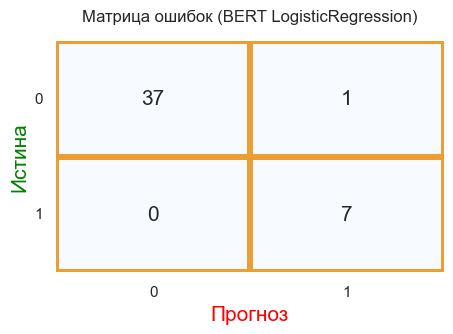

In [23]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.heatmap(cbc_conf_mtrx, ax=ax, annot=True, fmt='n', annot_kws={'fontsize':15},
            cbar=False, linewidths=3, linecolor='#eb9e34', cmap=plt.cm.Blues, center=25000)
ax.set_title('Матрица ошибок (BERT LogisticRegression)', fontsize=12, y=1.05)
ax.tick_params(axis='y', labelrotation=0)
ax.set_xlabel('Прогноз', fontsize = 15, color='red')
ax.set_ylabel('Истина', fontsize = 15, color='green')
plt.show()

Обучать BERT пришлось на logisticregression.

Итог даже на LogisticRegression оказался очень хороший, модель прошла и бейзлайн и порог проекта.

BERT обработал всего несколько сотен записей, больше моё железо не тянет, на более мощных машинах результат оказался бы значительно лучше.

**Вывод** Лучшая модель - BERT + LR.

Но, так как BERT это уже готовая модель обработки, то в качестве итогового тестирования посмотрим на TF-IDF + CatBoost

### Итоговое тестирование модели TF-IDF

In [24]:
predict = cb_model.predict(c_test_cb)
cb_conf_mtrx = confusion_matrix(y_test_cb, predict)
print(f1_score(predict, y_test_cb))

0.7582875229052141


CatBoost TF-IDF прошла порог проекта в 0.75

## Выводы

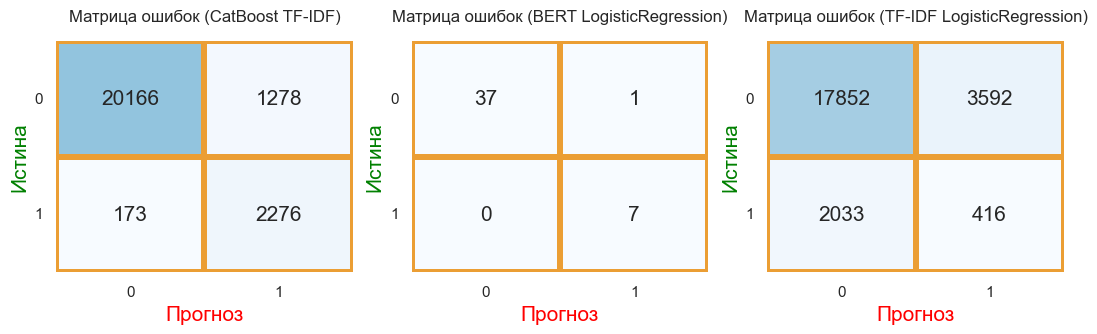

In [25]:
sns.set_theme(style='whitegrid')

fig, ax = plt.subplots(1, 3, figsize=(13, 3))

sns.heatmap(cb_conf_mtrx, ax=ax[0], annot=True, fmt='n', annot_kws={'fontsize':15},
            cbar=False, linewidths=3, linecolor='#eb9e34', cmap=plt.cm.Blues, center=25000)
sns.heatmap(cbc_conf_mtrx, ax=ax[1], annot=True, fmt='n', annot_kws={'fontsize':15},
            cbar=False, linewidths=3, linecolor='#eb9e34', cmap=plt.cm.Blues, center=25000)
sns.heatmap(lr_conf_mtrx, ax=ax[2], annot=True, fmt='n', annot_kws={'fontsize':15},
            cbar=False, linewidths=3, linecolor='#eb9e34', cmap=plt.cm.Blues, center=25000)

ax[0].set_title('Матрица ошибок (CatBoost TF-IDF)', fontsize=12, y=1.05)
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_xlabel('Прогноз', fontsize = 15, color='red')
ax[0].set_ylabel('Истина', fontsize = 15, color='green')

ax[1].set_title('Матрица ошибок (BERT LogisticRegression)', fontsize=12, y=1.05)
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_xlabel('Прогноз', fontsize = 15, color='red')
ax[1].set_ylabel('Истина', fontsize = 15, color='green')

ax[2].set_title('Матрица ошибок (TF-IDF LogisticRegression)', fontsize=12, y=1.05)
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_xlabel('Прогноз', fontsize = 15, color='red')
ax[2].set_ylabel('Истина', fontsize = 15, color='green')

plt.show()

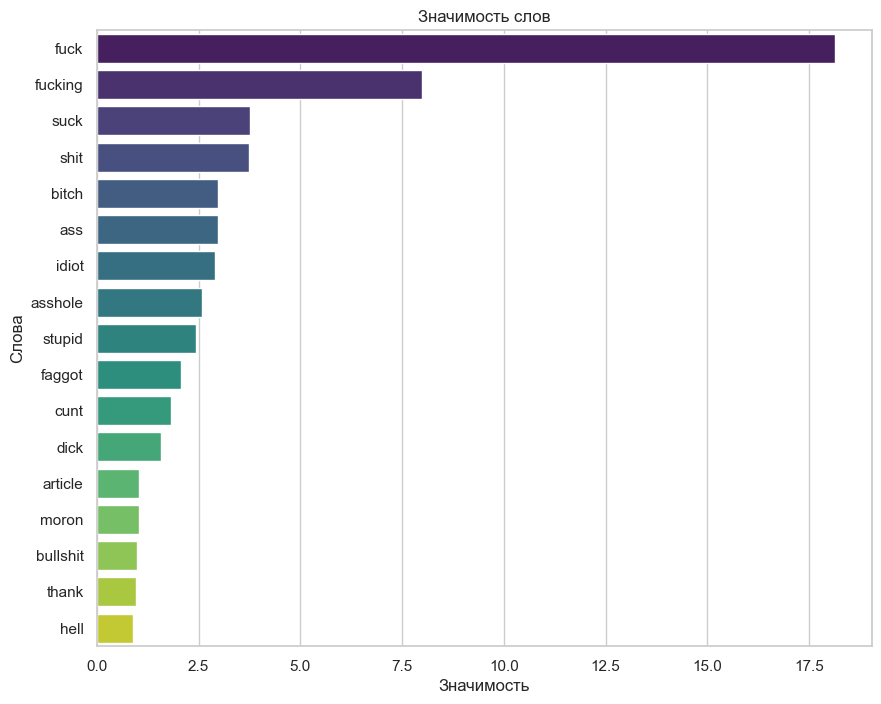

In [27]:
from catboost import Pool
feature_importance = cb_model.get_feature_importance()
words_list = []
importance_list = []
for i, importance in enumerate(feature_importance):
    if importance > 0.9:
        words_list.append([i])
        importance_list.append(importance)
words_list_w = []
for i in words_list:
    words = count_tf_idf.get_feature_names_out()
    words_list_w.append(words[i])
importance_f = pd.DataFrame()
importance_f['words'] = words_list_w
importance_f['importance'] = importance_list
importance_f['words'] = importance_f['words'].apply(lambda x: ', '.join(map(str, x)))
importance_f = importance_f.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='words', data=importance_f, palette='viridis')
plt.title('Значимость слов')
plt.xlabel('Значимость')
plt.ylabel('Слова')
plt.show()

Модель определила, что эти грубые слова зачастую влияют на токсичность комментария.

### Вывод:

В ходе данной работы я:
- Загрузил и предобработал данные.
- Лемматизировал текст (используя WordNetLemmatizer и Spacy).
- Использовал downsampling для борьбы с дисбалансом.
- Провёл TF-IDF обработку данных.
- Обучил модель CatBoost.
- Провёл обработку текста с помощью BERT.
- Обучил модель LogisticRegression.
- Построил confisuon matrix для обоих моделей.
- Провел исследование важности признаков для лучшей модели.


Три модели справляются с задачей неплохо, все прошли baseline-порог, но порог проекта в 0.75 прошли только CatBoost TF-IDF и BERT LR. Сравнив два лемматайзера - Spacy и WordNetLemmaizer, могу сказать, что качество модели после обработки Spacy немного лучше, чем WordNet, но второй, в свою очередь, имеет преимущество по скорости обработки текста.

TF-IDF справляется с задачей в разы быстрее, но ему нужно данных значительно больше, чем для BERT.

Из-за недостатка мощности BERT приходится обучать всего на 300 строках, если иметь более мощное железо - результат окажется лучше.

F1 score на BERT: 0.9333, F1 score на TF-IDF: 0.75.

Имеется список слов, появление которых значительно повышают вероятность классификации комментария к "токсичному".

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны